In [1]:
import numpy as np
import torch
from datasets.mnist1d import load_MNIST1D
from datasets.control import get_mixture_distribution, load_control
import os
import matplotlib.pyplot as plt

In [2]:
# mixture_list = [
#     # uniform between [-10, -5] and [5, 10] (for 2D data)
#     ("uniform",
#      np.array([-10.0, -5.0, -10, -10]),
#      np.array([5.0, 10.0, -5, 5])),

#     # normal with mean [10, 5, -5] and std [2, 12, 1]
#     ("normal",
#      np.array([10.0,  5.0, -5.0, -5]),
#      np.array([ 2.0, 12.0,  1.0, 1])),

#     # normal centered at 0 with unit variance in all dims
#     ("normal",
#      np.array([0.0, 0.0, 0.0, 0]),
#      np.array([1.0, 1.0, 1.0, 1])),

#     # normal with mean [3, 6, 2] and std [4, 5, 3]
#     ("normal",
#      np.array([3.0, 6.0, 2.0, 2]),
#      np.array([4.0, 5.0, 3.0, 3])),

#     # laplace centered at [4, 4, 4] with scale 1
#     ("laplace",
#      np.array([4.0, 4.0, 4.0, 4]),
#      np.array([1.0, 1.0, 1.0, 1])),

#     # normal centered at -5 with std 3 in all dims
#     ("normal",
#      np.array([-5.0, -5.0, -5.0, -5]),
#      np.array([3.0, 3.0, 3.0, 3])),

#     # exponential with scale=1 in all dims, then shifted by -5
#     ("exponential",
#      np.array([1.0, 1.0, 1.0, 1]),    # scale
#      np.array([-5.0, -5.0, -5.0, -5])), # shift
# ]


mixture_list = [
    ('uniform', np.array([-10.,  -5.]), np.array([ 5., 10.])),
    ('normal', np.array([10.,  5.]), np.array([ 2., 12.])),
    ('normal', np.array([0., 0.]), np.array([1., 1.])),
    ('normal', np.array([3., 6.]), np.array([4., 5.])),
    ('laplace', np.array([4., 4.]), np.array([1., 1.])),
    ('normal', np.array([-5., -5.]), np.array([3., 3.])),
    ('exponential', np.array([1., 1.]), np.array([-5., -5.]))
]

weights = [0.1, 0.2, 0.2, 0.1, 0.1, 0.2, 0.1]
# weights = [1]
control_data = get_mixture_distribution(mixture_list, weights, size=(20000, 2))

# Train GMMN

## Parameters

In [3]:
model_dir = "./model_weights"

BATCH_SIZE = 1000 # taken from original paper
# trainloader, testloader, min_value, max_value = load_MNIST1D(batch_size = BATCH_SIZE)
# trainloader, testloader = load_MNIST(batch_size = BATCH_SIZE, size=7, flatten=True)
trainloader, testloader, min_value, max_value = load_control(control_data, batch_size=1000)
for batch_inputs, batch_targets in trainloader:
    # Do training step here
    print(batch_inputs.shape, batch_targets.shape)
    break
N_INP = next(iter(trainloader))[0].shape[1]
NOISE_SIZE = 1
ENCODED_SIZE = N_INP 
N_ENCODER_EPOCHS = 2000
N_GEN_EPOCHS = 1000

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([1000, 2]) torch.Size([1000, 2])


## Train Autoencoder


Autoencoder Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]


Loaded saved autoencoder model
Autoencoder has been successfully trained


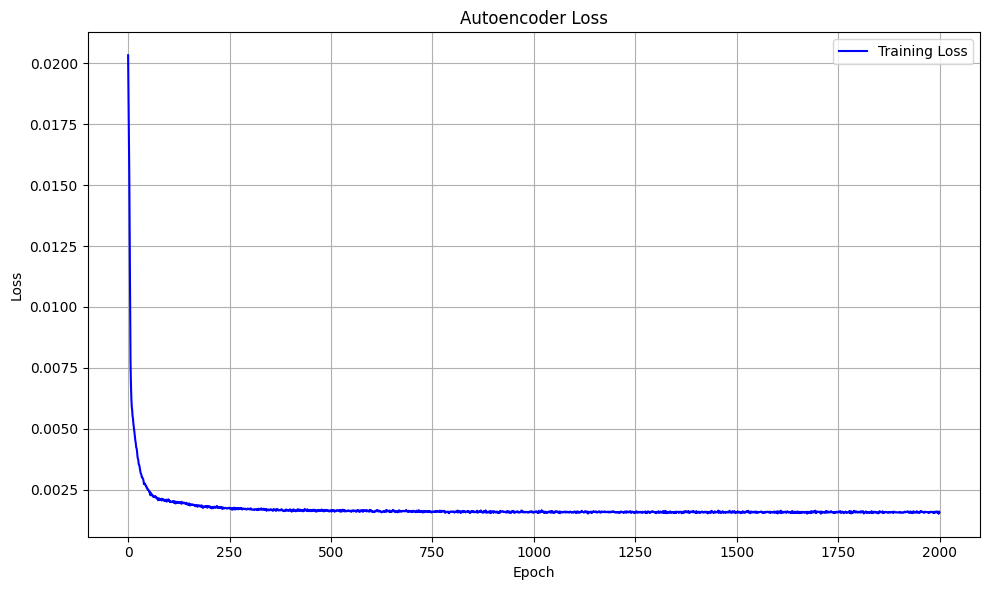

In [4]:
from models.gmmn.train_autoencoder import train_autoencoder
from visualization.loss import plot_loss

ENCODER_SAVE_PATH = model_dir + "/autoencoder_control-complex-distribution.pth"
autoencoder, losses_autoencoder = train_autoencoder(trainloader, N_INP, ENCODED_SIZE, N_ENCODER_EPOCHS, device, ENCODER_SAVE_PATH)
plot_loss(losses_autoencoder, title="Autoencoder Loss")

## Continue with GMMN


In [ ]:
from models.gmmn.train_gmmn import train_gmmn
sigmas = [2 ** i for i in range(0, 5)]  # Example: [1, 2, 4, 8, 16]
GMMN_SAVE_PATH = model_dir + "/gmmn_control-1000-relu-complex.pth"
gmm_net, losses_gmmn = train_gmmn(trainloader, autoencoder, sigmas, ENCODED_SIZE, NOISE_SIZE, BATCH_SIZE, N_GEN_EPOCHS, device, GMMN_SAVE_PATH)
plot_loss(losses_gmmn, title="GMMN Loss")

GMMN Training Progress:   3%|▎         | 30/1000 [02:22<1:10:54,  4.39s/it, Avg Loss=0.0236, Epoch=30/1000]

## Sample Visualizations

##### MNIST 1-D
**Run only if data used is MNIST-1D**

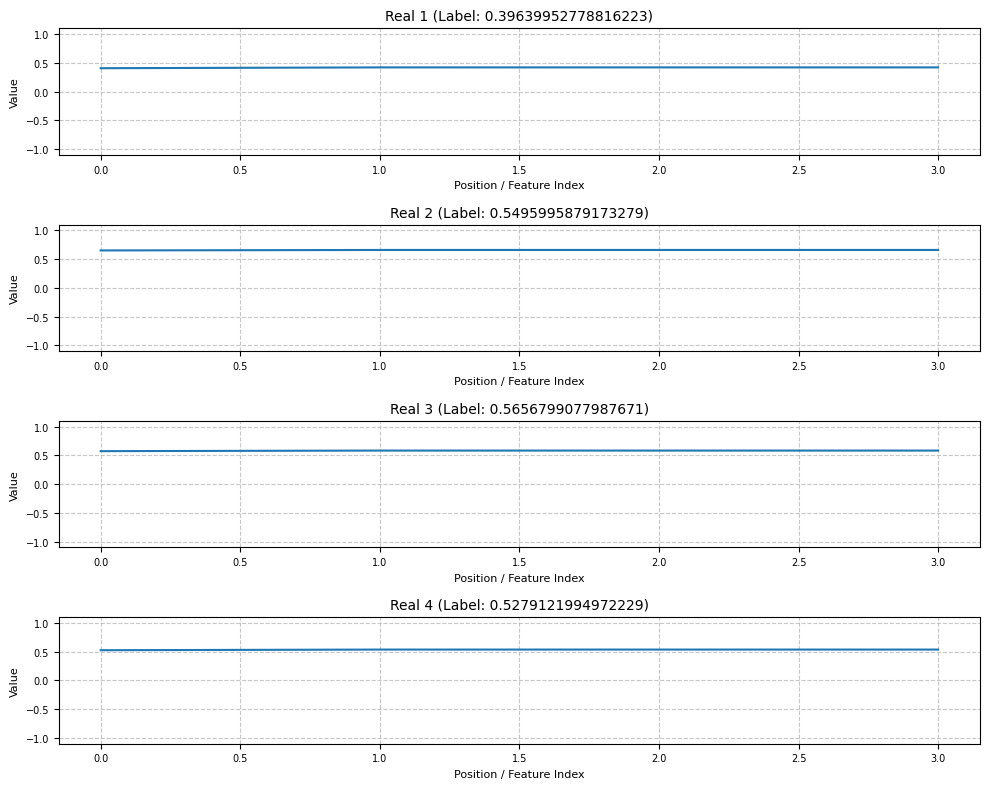

In [6]:
from visualization.visualize_1d_data import visualize_mnist1d
from models.gmmn.gmmn import generate_gmmn_samples

samples, labels = next(iter(trainloader))
visualize_mnist1d(samples, labels, title_prefix="Real")

In [ ]:
gen_samples = generate_gmmn_samples(gmm_net, autoencoder, NOISE_SIZE, 10)
visualize_mnist1d(gen_samples, labels, title_prefix="Generated")

##### Control Data
**Work only if working with control data**

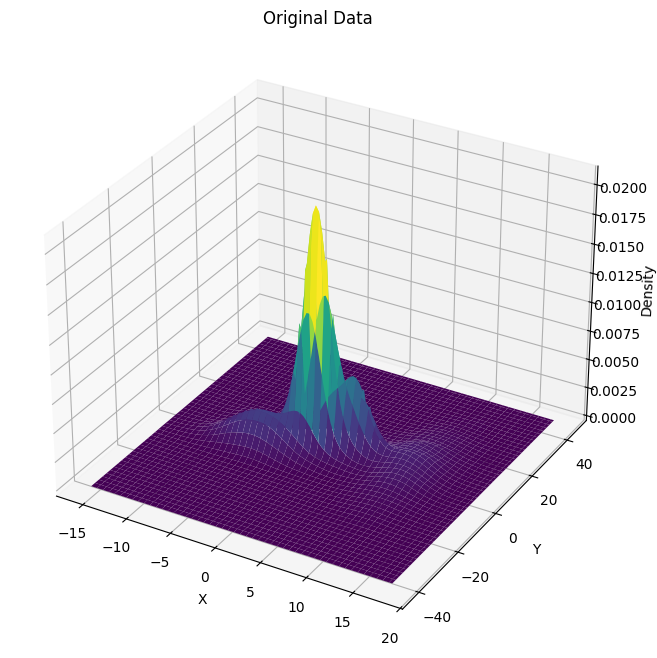

In [7]:
import visualization.plots
visualization.plots.plot_3d_kde(control_data, "Original Data")

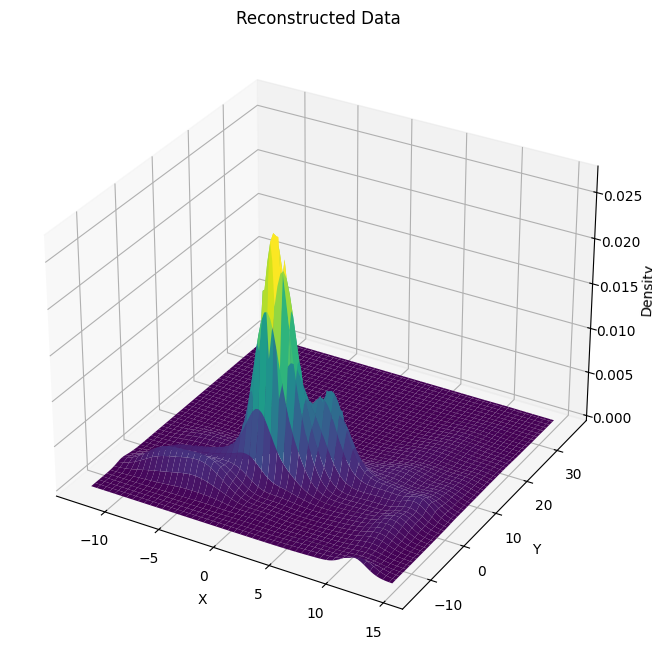

In [8]:
reconstructed_data = []
autoencoder.eval()
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(trainloader):
        reconstructed_data.append(autoencoder.forward(data)[1])
# print(reconstructed_data[0][0].shape)
reconstructed_data = torch.cat(reconstructed_data, dim=0).numpy()
reconstructed_data = np.add(np.multiply(max_value - min_value, reconstructed_data), min_value)
# reconstructed_data = np.array(reconstructed_data)
visualization.plots.plot_3d_kde(reconstructed_data, "Reconstructed Data")

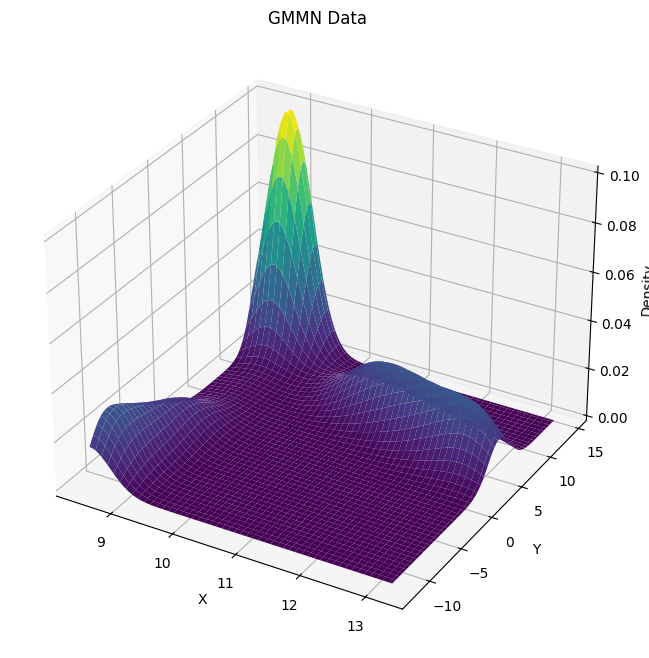

In [15]:
from models.gmmn.gmmn import generate_gmmn_samples
gen_samples = generate_gmmn_samples(gmm_net, autoencoder, NOISE_SIZE, 10000)
gen_samples = np.add(np.multiply(max_value - min_value, gen_samples), min_value)
visualization.plots.plot_3d_kde(gen_samples, "GMMN Data")

In [44]:
gen_samples[:10]

array([[ 6.40830148, -1.88420153],
       [10.48939759, 19.15262118],
       [ 6.63908414, -0.92908897],
       [ 6.78385176, -0.35823869],
       [10.4886254 , 18.82086087],
       [10.4891795 , 19.26458122],
       [10.49082092, 18.35697611],
       [ 6.35798296, -2.10076959],
       [11.41843022, -2.5432866 ],
       [10.02147216, 14.52460113]])

## Bootstrapping Hypothesis Test

In [ ]:
from utilities.bootstrapping_test import bootstrap_hypothesis_test

original_data = []
for batch_idx, (data, labels) in enumerate(trainloader):
    original_data.append(data.cpu()) # .cpu() if data is on GPU
original_data = torch.cat(original_data, dim=0)
original_data = np.squeeze(original_data.numpy())
generating_function = generate_gmmn_samples
gen_args = (gmm_net, autoencoder, NOISE_SIZE, 20000)
alpha = 0.05
num_iterations = 1000

bootstrap_hypothesis_test(original_data, generating_function, gen_args, alpha, num_iterations)